In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# CONSTANTS
DATA_PATH   = '../resources/model_datasets.npz'
GRID_PATH   = '../resources/model_results/decision_tree_grid.npy'
MODEL_PATH  = '../resources/best_models/decision_tree.npy'
TRAIN_MODEL = False

# Decision Tree Model

### Load the data

In [3]:
# Extract the arrays from the NPZ file
with np.load(DATA_PATH, allow_pickle=True) as npz: 
    X_train = npz['X_train'] 
    X_test = npz['X_test']
    y_train = npz['y_train']
    y_test = npz['y_test']
    Ids_train = npz['Ids_train']
    Ids_test = npz['Ids_test']
    candidates = npz['candidates']
    candidate_ids = npz['candidate_ids']
    feature_names = npz['feature_names']
    label_names = npz['label_names']
    
# Check shapes
print('Training set shape:', X_train.shape, y_train.shape)
print('Test set shape:', X_test.shape, y_test.shape)

# Label counts
pd.DataFrame({
    'count': pd.value_counts(y_train), 
    'normalized': pd.value_counts(y_train, normalize=True)}
)

Training set shape: (3000, 21) (3000,)
Test set shape: (898, 21) (898,)


,count,normalized
0,1761,0.587
1,1239,0.413


### Hyperparameters tuning

Decision trees tend to quickly overfit the training data as its depth increase. Because trees segment the predictor space into a number of regions, we can expect that applying PCA to reduce the number of dimensions of this space by building higher level predictors keeping a huge proportion of the original variance should be profitable.

The following hyperparameters will be tuned by grid search and 5-folds cross-validation:

* PCA number of components 
* Maximum depth of the tree 
* Number of features to consider when looking for the best split

Note that because the imbalance of our target variable, we apply weights inversely proportional to class frequencies: `class_weight='balanced'`.

In [4]:
# Hyperparameters
pca__n_components = [9, 12, 15, 18, None]  # variance explained: 80%, 90%, 95%, 99%, 100%
dt__max_depth = np.arange(1, 21)
dt__max_features = [0.25, 1/3, 0.5, 2/3, 0.75]

    
# Train the model if required
if TRAIN_MODEL:
    
    # Pipeline estimator
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=0)),
        ('dt', DecisionTreeClassifier(criterion='gini', class_weight='balanced' , random_state=0))
    ])

    # Grid parameters
    grid = ParameterGrid({
        'pca__n_components': pca__n_components,
        'dt__max_depth': dt__max_depth,
        'dt__max_features': dt__max_features
    })
    
    # Grid Search with cross-validation
    grid_cv = GridSearchCV(
        pipe,
        grid.param_grid,
        cv=5,  # 5 folds => 2400 training, 600 validation
        scoring=['accuracy', 'precision', 'recall'],
        refit=False,
        verbose=3
    )

    # Fit the model
    grid_cv.fit(X_train, y_train)
    
    # Save results in a numpy file
    np.save(GRID_PATH, grid_cv)
else:
    # Load the grid search results from file
    grid_cv = np.load(GRID_PATH, allow_pickle=True).item(0)

### Model selection

We can extract the results and build a dataframe to analyze them:

In [5]:
# We want to tune our models according to the precision metric
score = 'precision'

# Generic variable names to easely change the metric
r = grid_cv.cv_results_
mean_train_score = 'mean_train_' + score
mean_valid_score = 'mean_test_' + score
std_train_score  = 'std_train_' + score
std_valid_score  = 'std_test_' + score

# Create a DataFrame to analyze the grid search results
df = pd.DataFrame.from_items([
    ('n_components', r['param_pca__n_components']),
    ('max_depth', r['param_dt__max_depth']),
    ('max_features', r['param_dt__max_features']),
    ('mean_train_score', r[mean_train_score]),
    ('mean_valid_score', r[mean_valid_score]),
    ('delta_score', np.abs(r[mean_train_score] - r[mean_valid_score])),
    ('std_train_score', r[std_train_score]),
    ('std_valid_score', r[std_valid_score])
])

# Replace the PCA None value by the number of features
df.n_components.fillna(X_train.shape[1], inplace=True)

print('Number of models:', df.shape[0])
df.head(5)

Number of models: 500


,n_components,max_depth,max_features,mean_train_score,mean_valid_score,delta_score,std_train_score,std_valid_score
0,9,1,0.25,0.580148,0.577133,0.003016,0.008257,0.015965
1,12,1,0.25,0.577909,0.574112,0.003797,0.009372,0.018783
2,15,1,0.25,0.513591,0.504864,0.008727,0.014862,0.013368
3,18,1,0.25,0.551951,0.550664,0.001287,0.004057,0.016216
4,21,1,0.25,0.527095,0.519678,0.007417,0.016680,0.019941


The following scatter plots will give us better insight about the results :

* mean training score VS validation standard deviation
* mean validation score VS validation standard deviation
* delta mean scores VS validation standard deviation

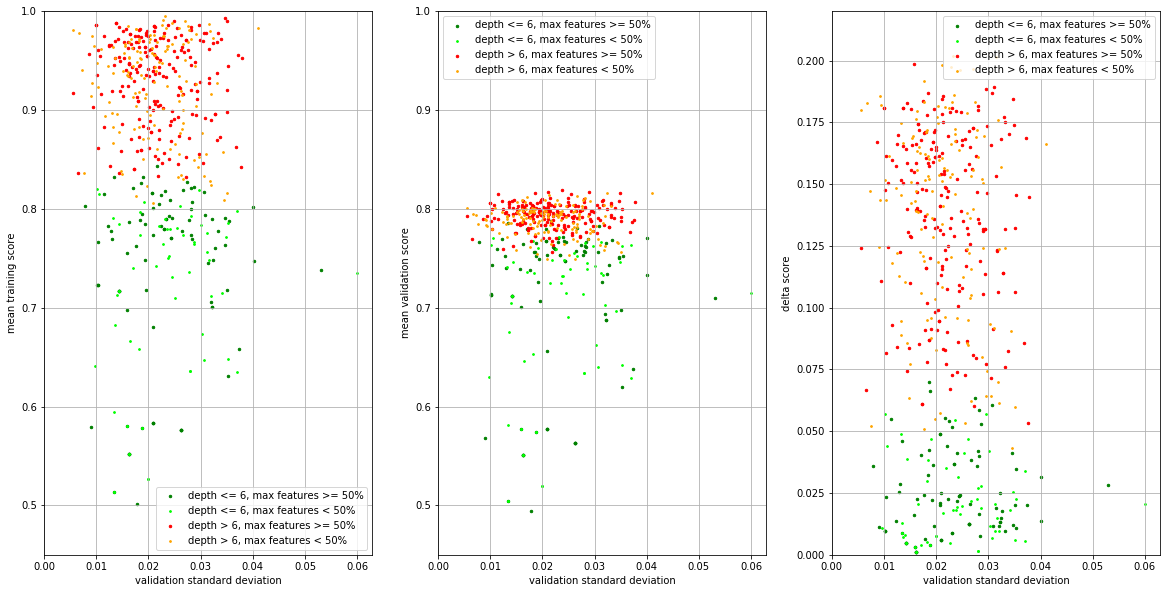

In [6]:
# Selection filters
depth_filter = (df.max_depth <= 6)
feature_filter = (df.max_features >= 0.5)

# Plot vars
legend_loc = ['lower right', 'upper left', 'upper right']
ylabel = ['mean training score', 'mean validation score', 'delta score']
ylims = [(0.45, 1), (0.45, 1), (0, 0.22)]

i = 0
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
for var in ['mean_train_score', 'mean_valid_score', 'delta_score']:
    ax[i].scatter(df.std_valid_score[depth_filter & feature_filter], df.loc[depth_filter & feature_filter, var], color='green', label='depth <= 6, max features >= 50%', s=6)
    ax[i].scatter(df.std_valid_score[depth_filter & ~feature_filter], df.loc[depth_filter & ~feature_filter, var], color='#00FF00', label='depth <= 6, max features < 50%', s=3)
    ax[i].scatter(df.std_valid_score[~depth_filter & feature_filter], df.loc[~depth_filter & feature_filter, var], color='red', label='depth > 6, max features >= 50%', s=6)
    ax[i].scatter(df.std_valid_score[~depth_filter & ~feature_filter], df.loc[~depth_filter & ~feature_filter, var], color='orange', label='depth > 6, max features < 50%', s=3)    
    ax[i].grid(axis='both')
    ax[i].set(xlabel='validation standard deviation', ylabel=ylabel[i], xlim=(0, ax[i].get_xlim()[1]), ylim=ylims[i])
    ax[i].legend(loc=legend_loc[i])
    i += 1

plt.show()

The overfitting induced by the increase of the maximum tree depth is clearly visible. As soon as the tree depth is greater than 6, the difference between the validation and training precision scores are greater than 5%.

Most of the models have a standard deviation between 1% and 4%. It's okish but a rule of thumb say that it's generally not good enough for production. Good models should have validation standard deviation less than 1%.

Given the results, our wish would be to find a model satisfying the following conditions:

* validation standard deviation <= 1%
* mean validation precision >= 75%
* delta mean precision <= 5%

In [7]:
# Model selection according to some wished criteria
f_std_valid = (df.std_valid_score <= 0.01)
f_score_valid = (df.mean_valid_score >= 0.75)
f_delta_score = (df.delta_score <= 0.05)

filter = f_std_valid & f_score_valid & f_delta_score
best_models = df[filter].sort_values(by='delta_score', ascending=True)
best_models

,n_components,max_depth,max_features,mean_train_score,mean_valid_score,delta_score,std_train_score,std_valid_score
116,12,5,0.666667,0.802843,0.766857,0.035985,0.01194,0.007893


Only one model fullfill these conditions. We can plot the training and validation curvers of the precision score VS the tree depth:

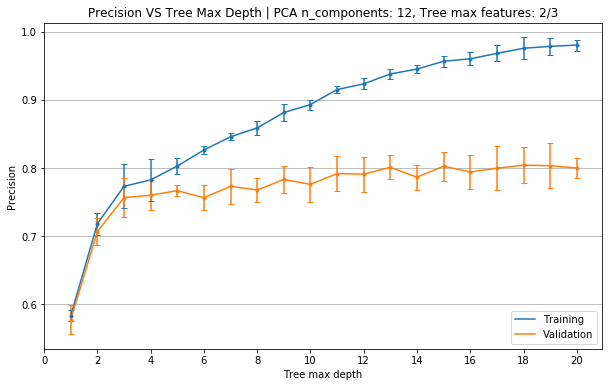

In [8]:
filter = (df.n_components == 12) & (df.max_features == 2/3)

# Plot the training and validation curves
plt.figure(figsize=(10, 6))

plt.plot(df.max_depth[filter], df.mean_train_score[filter], label='Training', color='C0')
plt.errorbar(df.max_depth[filter], df.mean_train_score[filter], df.std_train_score[filter], linestyle='None', marker='.', capsize=3, color='C0', label=None)

plt.plot(df.max_depth[filter], df.mean_valid_score[filter], label='Validation', color='C1')
plt.errorbar(df.max_depth[filter], df.mean_valid_score[filter], df.std_valid_score[filter], linestyle='None', marker='.', capsize=3, color='C1', label=None)
plt.title('Precision VS Tree Max Depth | PCA n_components: 12, Tree max features: 2/3')
plt.xlabel('Tree max depth')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.xticks(np.arange(0, 21, step=2))
plt.grid(axis='y')

Our selected model with its max depth at 5 appears to have a particularly smaller validation standard deviation compared to the other models, all others hyperparameters equals. Note that it is also the first validation precision maxima.

This model should be reliable...

### Best model evaluation on the test set

We must now to train these model on the full training set and evaluate it on the test set :

In [9]:
# Best model hyperparameters
n_components = best_models.n_components.values[0]
max_depth = best_models.max_depth.values[0]
max_features = best_models.max_features.values[0]


if TRAIN_MODEL:
    
    # Train the best model on the full training set
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components, random_state=0)),
        ('dt', DecisionTreeClassifier(max_depth=max_depth, 
                                      max_features=max_features, 
                                      criterion='gini', 
                                      class_weight='balanced', 
                                      random_state=0))
    ])
    pipe.fit(X_train, y_train)
    
    # Save the model in a numpy file
    np.save(MODEL_PATH, pipe)

else:
    # Load the model from file
    pipe = np.load(MODEL_PATH, allow_pickle=True).item(0)

In [10]:
# Get the predictions 
y_pred_tr = pipe.predict(X_train)
y_pred_te = pipe.predict(X_test)

# Get the contingency matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_te).ravel()

# Print the results
print('Evaluation of the best model on the test set:')
print('---------------------------------------------')
print('Decision Tree Precision (training set): ', np.round(precision_score(y_train, y_pred_tr), 3))
print('Decision Tree Precision (test set) : ', np.round(precision_score(y_test, y_pred_te), 3))
print('\n')
print('Confusion Matrix (test set):')
print('----------------------------\n')
print('                Actual N\tActual P\nPredicted N\t{:3d} (TN)\t{:3d} (FN)\nPredicted P\t{:3d} (FP)\t{:3d} (TP)'.format(tn, fn, fp, tp))
print('\n')
print('Metric Summary (test set):')
print('-------------------------- ')
print('Precision : ', np.round(precision_score(y_test, y_pred_te), 3))
print('Recall    : ', np.round(recall_score(y_test, y_pred_te), 3))
print('Accuracy  : ', np.round(accuracy_score(y_test, y_pred_te), 3))
print('F1 Score  : ', np.round(f1_score(y_test, y_pred_te), 3))

Evaluation of the best model on the test set:
---------------------------------------------
Decision Tree Precision (training set):  0.819
Decision Tree Precision (test set) :  0.819


Confusion Matrix (test set):
----------------------------

                Actual N	Actual P
Predicted N	456 (TN)	 50 (FN)
Predicted P	 71 (FP)	321 (TP)


Metric Summary (test set):
-------------------------- 
Precision :  0.819
Recall    :  0.865
Accuracy  :  0.865
F1 Score  :  0.841


The training and test precision scores are close, even equal indicating that our model generalizes well the data.  
This model is clearly better than the baseline models. With a precision score of 82% and a recall of 86%, it appears to be a well balanced model.